In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import seaborn as sns
from datetime import datetime

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('C:/Users/Rshs/Documents/python notebooks/mldatasets/TCS.csv',sep=',', parse_dates=['Date'], date_parser=dateparse)
df.head()

C:\Users\Rshs\AppData\Local\Temp/ipykernel_10144/1666060968.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-08-25,TCS,EQ,850.00,1198.7,1198.7,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
1,2004-08-26,TCS,EQ,987.95,992.0,997.0,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2,2004-08-27,TCS,EQ,979.00,982.4,982.4,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
3,2004-08-30,TCS,EQ,962.65,969.9,990.0,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
4,2004-08-31,TCS,EQ,986.75,986.5,990.0,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624


In [3]:
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15))

4272   2021-11-09
4273   2021-11-10
4274   2021-11-11
4275   2021-11-12
4276   2021-11-15
4277   2021-11-16
4278   2021-11-17
4279   2021-11-18
4280   2021-11-22
4281   2021-11-23
4282   2021-11-24
4283   2021-11-25
4284   2021-11-26
4285   2021-11-29
4286   2021-11-30
Name: Date, dtype: datetime64[ns]


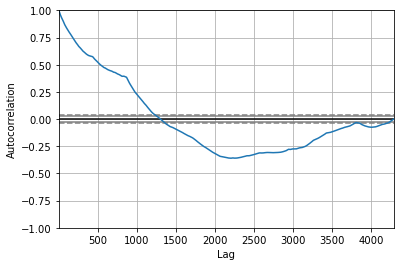

In [4]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Close'])
plt.show()


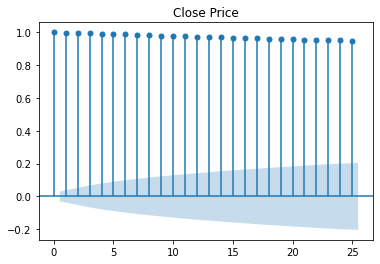

In [5]:
# Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['Close'],lags=25,title="Close Price")
plt.show()

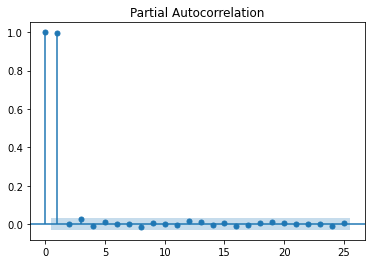

In [6]:
plot_pacf(df["Close"],lags=25)
plt.show()

In [7]:
#Variables for training
cols = list(df)[3:9]
#Date and volume columns are not used in training. 
print(cols) #['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close']

['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close']


In [8]:
df_for_training = df[cols].astype(float)

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [10]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [11]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (4273, 14, 6).
trainY shape == (4273, 1).


In [12]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(trainX, trainY, epochs=5, batch_size=2, validation_split=0.1, verbose=1)



Epoch 1/5
1923/1923 [==============================] - 40s 19ms/step - loss: 0.0436 - val_loss: 0.0217
Epoch 2/5
1923/1923 [==============================] - 36s 19ms/step - loss: 0.0289 - val_loss: 0.0056
Epoch 3/5
1923/1923 [==============================] - 37s 19ms/step - loss: 0.0286 - val_loss: 0.0223
Epoch 4/5
1923/1923 [==============================] - 38s 20ms/step - loss: 0.0262 - val_loss: 0.0365
Epoch 5/5
1923/1923 [==============================] - 36s 19ms/step - loss: 0.0244 - val_loss: 0.0143


In [14]:
pre = model.predict(trainX)

In [15]:
n_past = 2
n_days_for_prediction=10

In [39]:
prediction = model.predict(trainX[-n_days_for_prediction:]) #
#prediction = model.predict(trainX[-n_past:])

In [40]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

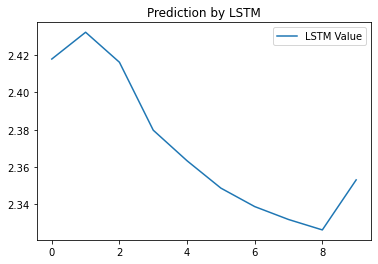

In [41]:
plt.plot(prediction, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.legend()
plt.show()

In [46]:
index = pd.DataFrame({'Date':['2021-12-01','2021-12-02','2021-12-03','2021-12-04','2021-12-05','2021-12-06','2021-12-07','2021-12-08','2021-12-09','2021-12-10']})

In [47]:
index['Date']=pd.to_datetime(index['Date'],infer_datetime_format=True)
index=index.set_index(['Date'])
from datetime import datetime
index.head()

""
Date
2021-12-01
2021-12-02
2021-12-03
2021-12-04
2021-12-05


In [48]:
index['Close'] = y_pred_future


In [52]:
index

,Close
Date,
2021-12-01,3633.388672
2021-12-02,3644.555664
2021-12-03,3632.047607
2021-12-04,3603.736572
2021-12-05,3590.989502
2021-12-06,3579.594482
2021-12-07,3571.901367
2021-12-08,3566.522461
2021-12-09,3562.177979


<AxesSubplot:xlabel='Date'>

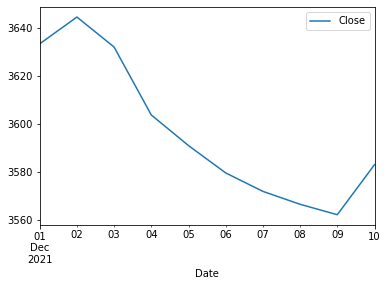

In [49]:
index.plot()

In [50]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df1 = pd.read_csv('C:/Users/Rshs/Documents/python notebooks/mldatasets/TCS.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse)


C:\Users\Rshs\AppData\Local\Temp/ipykernel_10144/3994254061.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


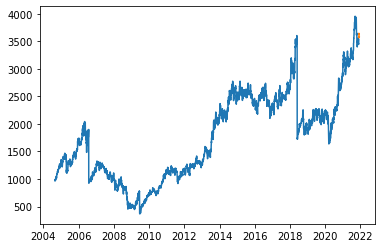

In [51]:
import matplotlib.pyplot as plt
plt.plot(df1.Close)
plt.plot(index)
